# Diamond Price Prediction (Regression)

Dataset Link: https://www.kaggle.com/datasets/shivam2503/diamonds/data  

Algorithms: Linear Regression, Random Forest

Load Dataset

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [82]:
# Load the data
data = pd.read_csv('diamonds.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Dataset Description: 

**price:** price in US dollars (\$326--\$18,823)

**carat:** weight of the diamond (0.2--5.01)

**cut:** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color:** diamond colour, from J (worst) to D (best)

**clarity:** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x:** length in mm (0--10.74)

**y:** width in mm (0--58.9)

**z:** depth in mm (0--31.8)

**depth:** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table:** width of top of diamond relative to widest point (43--95)

In [83]:
# remove the first column
data = data.drop(data.columns[0], axis=1)

In [84]:
# check for missing values
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### Exploratory Data Analysis (EDA)

In [85]:
# summary of the data
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


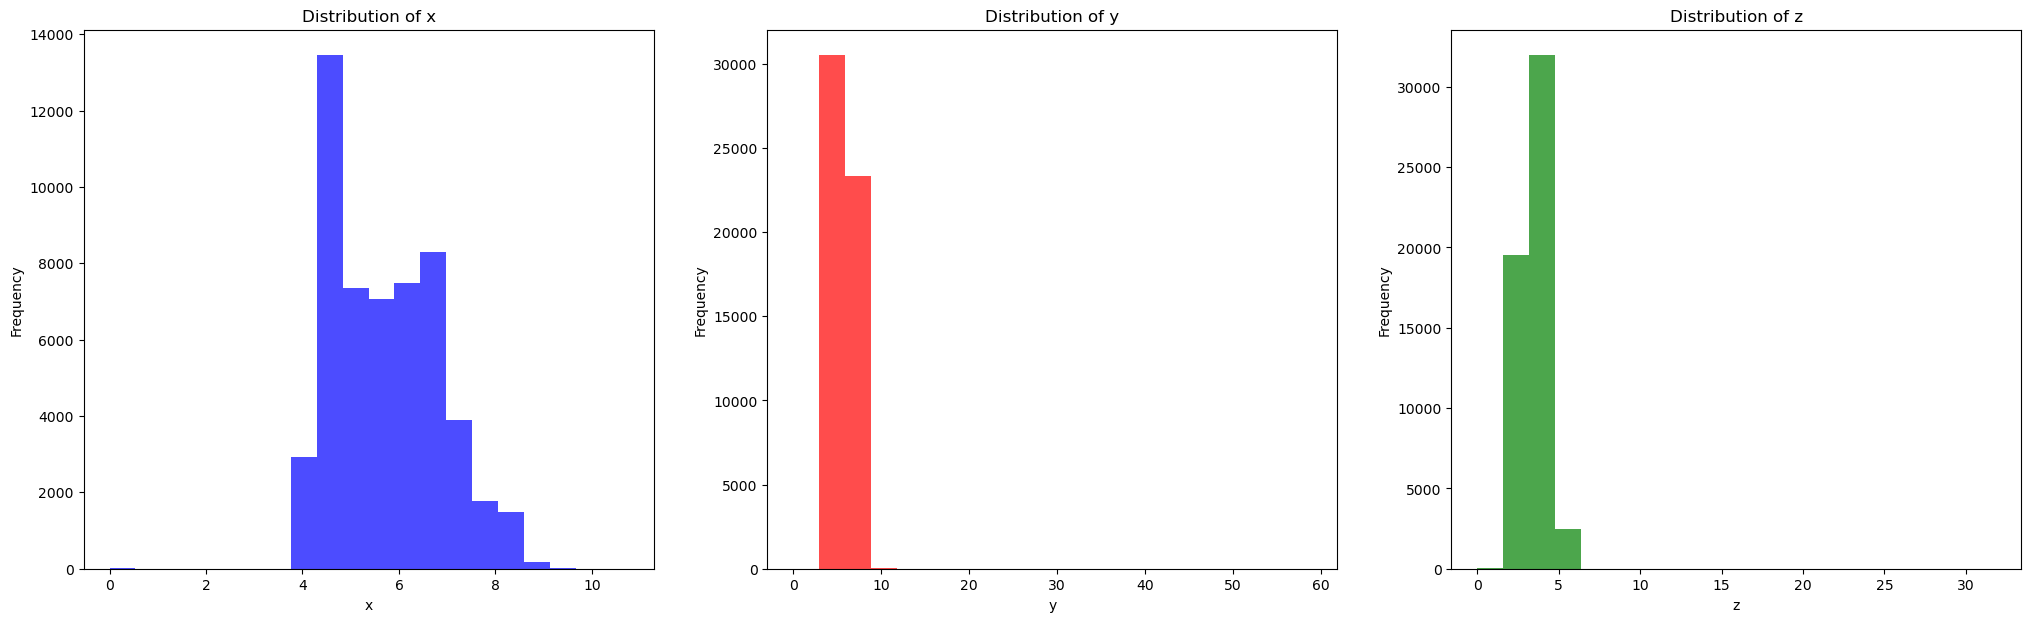

In [53]:
# Distribution of x, y, z
plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
plt.hist(data['x'], bins=20, color='blue', alpha=0.7)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of x')

plt.subplot(1, 3, 2)
plt.hist(data['y'], bins=20, color='red', alpha=0.7)
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of y')

plt.subplot(1, 3, 3)
plt.hist(data['z'], bins=20, color='green', alpha=0.7)
plt.xlabel('z')
plt.ylabel('Frequency')
plt.title('Distribution of z')
plt.show()


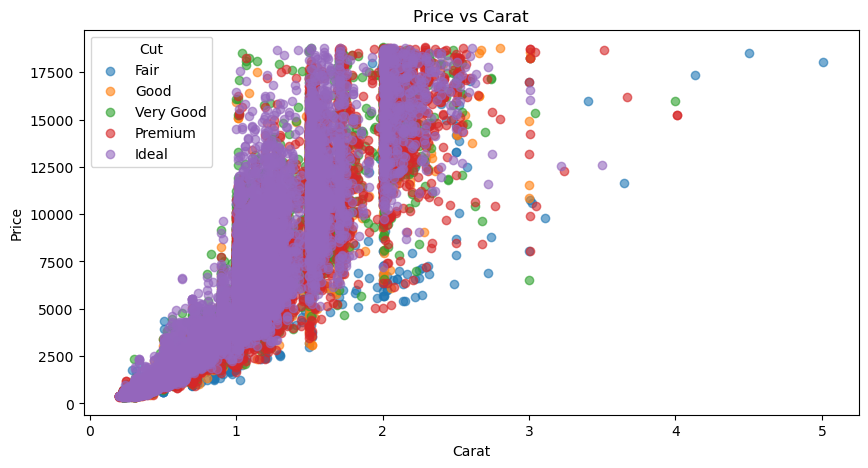

In [64]:
# find relationship between price and carat and cuts as legend 
plt.figure(figsize=(10, 5))
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
for cut in cut_order:
    subset = data[data['cut'] == cut]
    plt.scatter(subset['carat'], subset['price'], label=cut, alpha=0.6)

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Price vs Carat')
plt.legend(title="Cut")
plt.show()

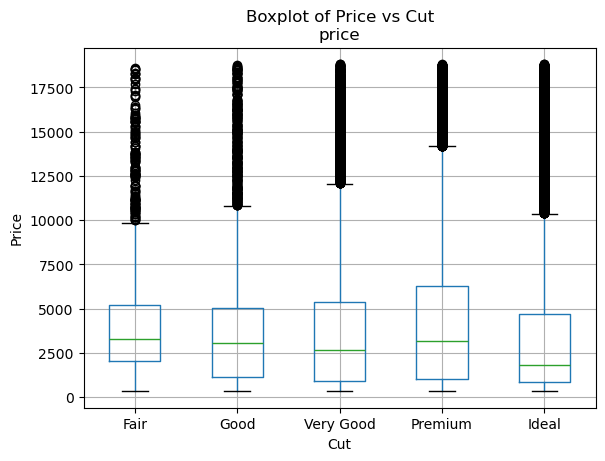

In [33]:
# Find distribution between price and cuts sort by fair, good, very good, premium, ideal
data['cut'] = pd.Categorical(data['cut'], categories=cut_order, ordered=True)
data.boxplot(column='price', by='cut')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.suptitle('Boxplot of Price vs Cut')
plt.show()


## Correlation Matrix


In [86]:
# turn categorical data into numerical data (one hot encoding)
data = pd.get_dummies(data)
data.head()


,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False


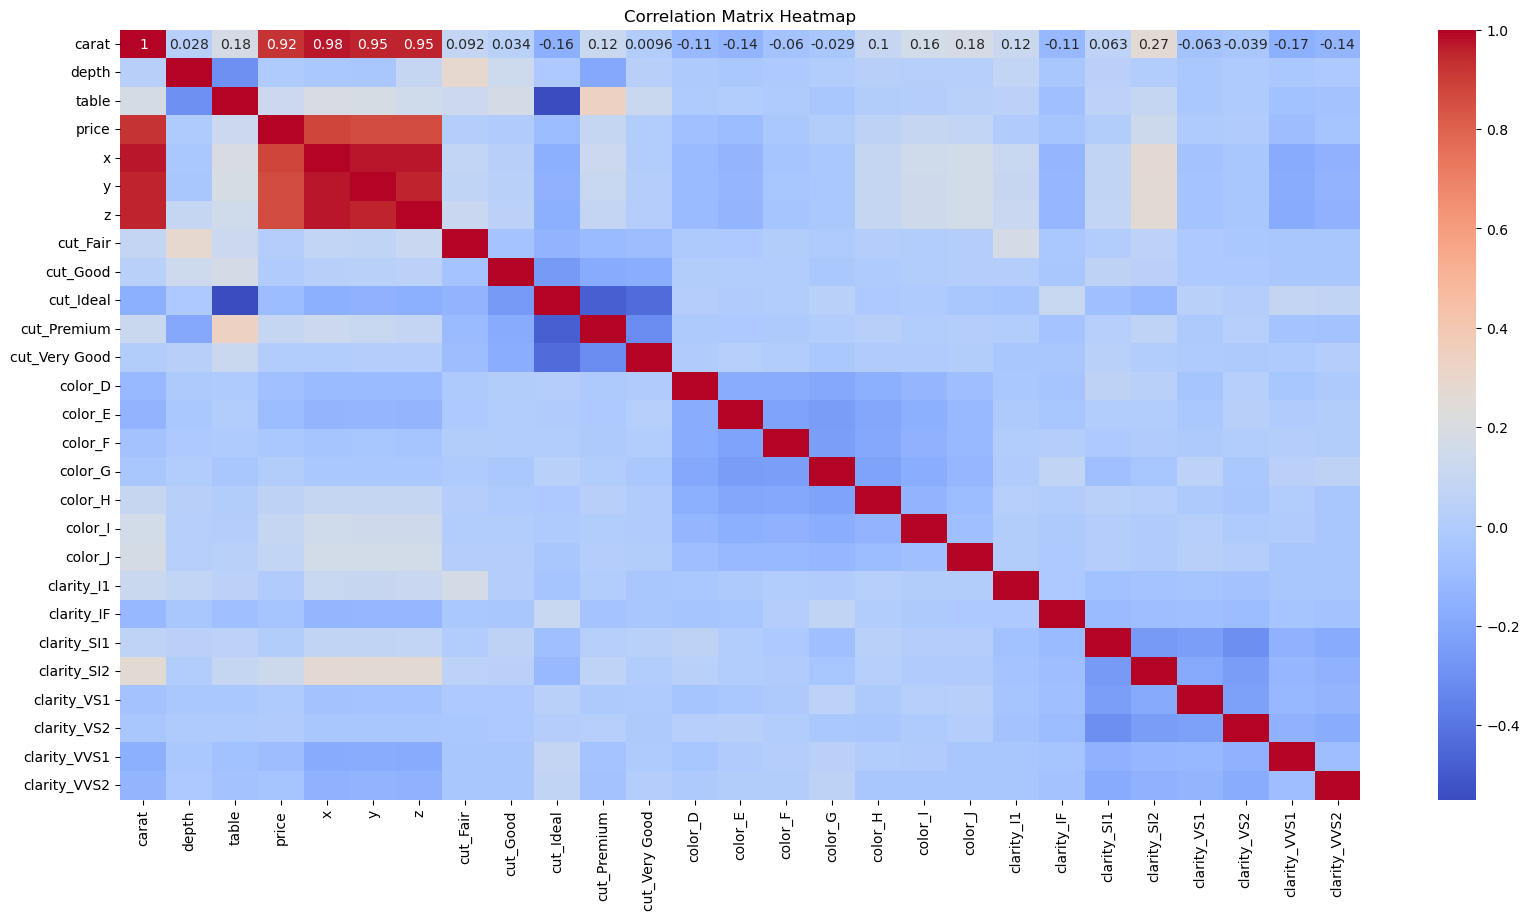

In [94]:
# Correlation matrix heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Model Training

### Linear Regression

In [107]:
# split train and test data
from sklearn.model_selection import train_test_split
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [108]:
# Linear Regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [109]:
# Model Evaluation mse, rmse, r2, mae
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')




Mean Squared Error: 1316812.6996517961
Root Mean Squared Error: 1147.5245965345562
R2 Score: 0.9184458469545096
Mean Absolute Error: 738.9269503951148


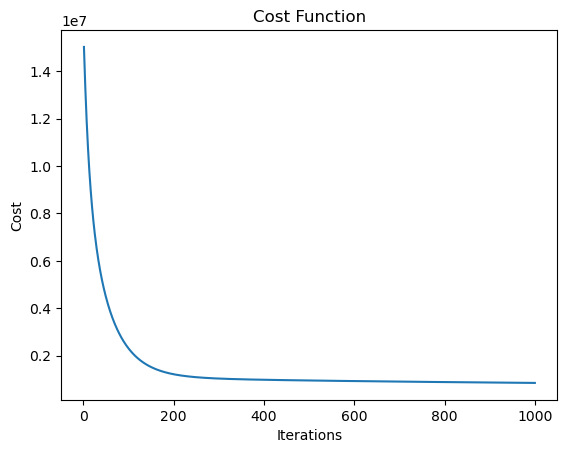

In [111]:
# Cost function J
def cost_function(X, y, theta):
    m = len(y)
    J = np.sum((X.dot(theta) - y) ** 2) / (2 * m)

    return J

# Gradient Descent
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        theta = theta - (alpha / m) * X.T.dot(X.dot(theta) - y)
        cost_history[i] = cost_function(X, y, theta)

    return theta, cost_history

# Normalize the data
X = (X - X.mean()) / X.std()

# Add a column of ones to X
X = np.c_[np.ones(X.shape[0]), X]

# Initialize theta
theta = np.zeros(X.shape[1])

# Set hyperparameters
alpha = 0.01
iterations = 1000

# Run gradient descent
theta, cost_history = gradient_descent(X, y, theta, alpha, iterations)

# Plot the cost function
plt.plot(range(1, iterations + 1), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function')
plt.show()



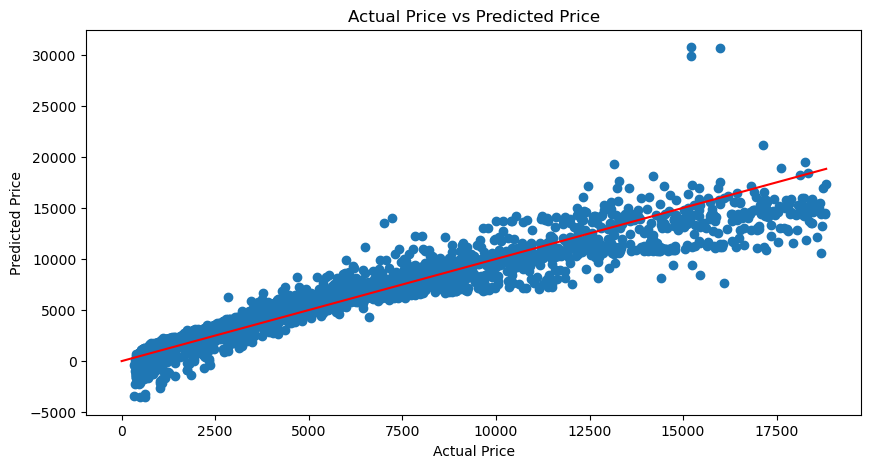

In [112]:
# plot the predicted price vs actual price with regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()


### Random Forest